# Set up

In [1]:
# update path with data dir
import sys
sys.path.append('../data/')
sys.path.append('../modelling/')

In [2]:
import player_data as player
import goodness_fit
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

/home/tom/footbot/venv/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Get data

In [3]:
file_name = 'csvs/element_gameweek_' + datetime.today().strftime('%Y-%m-%d') + '.csv'

In [4]:
try:
    element_gameweek_df = pd.read_csv(file_name)
except:
    element_gameweek_df = player.get_element_gameweek_df()
    element_gameweek_df.to_csv(file_name)

In [5]:
current_event = 30
element_types = [2, 3, 4]
threshold_minutes = 1

In [6]:
element_gameweek_df =\
element_gameweek_df[
    (element_gameweek_df['event'] <= current_event)
    & (element_gameweek_df['element_type'].isin(element_types))
    & (element_gameweek_df['minutes'] >= threshold_minutes)
]

In [7]:
player.add_home_categorical_variable(element_gameweek_df)

# Poisson player minutes model

## Preparing data

In [8]:
sppmm_df = element_gameweek_df.copy()

In [9]:
sppmm_df = player.add_categorical_variables(sppmm_df, 'opposition_team')
sppmm_df = player.add_categorical_variables(sppmm_df, 'element')

In [10]:
sppmm_redundant_columns = [
    'row_id', 'assists', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'was_home', 'minutes'
]

In [11]:
sppmm_df['log_minutes'] = np.log(sppmm_df['minutes'])

In [12]:
sppmm_df = player.remove_redundant_columns(sppmm_df, sppmm_redundant_columns)

In [13]:
sppmm_response_df, sppmm_explanatory_df = player.get_response_explanatory_dfs(sppmm_df, 'goals_scored')

## Fitting model

In [14]:
sppmm_results = sm.GLM(
    sppmm_response_df,
    sppmm_explanatory_df,
    family=sm.families.Poisson(),
    missing='drop'
).fit()

In [15]:
print(sppmm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           goals_scored   No. Observations:                 7649
Model:                            GLM   Df Residuals:                     7170
Model Family:                 Poisson   Df Model:                          478
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -2048.1
Date:                Sun, 17 Mar 2019   Deviance:                       2585.8
Time:                        08:54:23   Pearson chi2:                 5.61e+03
No. Iterations:                    25                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -4.5824      0.712     -6.434      0.000      -5.978      -3.186
opposition_team_2      0.313

## Model fit

In [37]:
sppmm_results.aic

5054.161947454179

In [38]:
sppmm_results.bic

-61530.68640581876

In [16]:
sppmm_pearson_results = goodness_fit.pearson_chi_squared_test(sppmm_results)
sppmm_pearson_results

(False, 1.0)

### Significant explanatory variable

In [17]:
sppmm_results.params[sppmm_results.pvalues < 0.10]

const                -4.582429
opposition_team_4     0.436140
opposition_team_5     0.454725
opposition_team_9     0.599525
opposition_team_12   -0.743237
opposition_team_13   -0.501039
element_27           -1.938843
element_60           -1.936242
element_82           -2.059867
element_115          -1.944639
element_118          -2.036475
element_138          -1.959473
element_142          -2.103047
element_162          -1.990800
element_192          -2.094157
element_280           1.079923
element_296          -1.915954
element_317          -1.952172
element_389          -1.946911
element_409          -2.060522
element_427          -2.035709
element_475          -1.995804
log_minutes           0.705431
dtype: float64

### Residuals

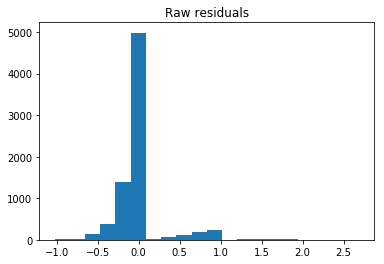

In [18]:
plt.figure()
plt.hist(sppmm_results.resid_response, bins=20)
plt.title('Raw residuals')
plt.show()

/home/tom/footbot/venv/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:340: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(2 * (endog * np.log(endog_mu) - (endog - mu))) / scale)
/home/tom/footbot/venv/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/tom/footbot/venv/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


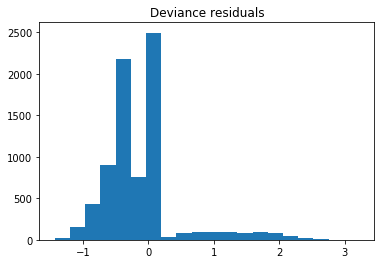

In [19]:
plt.figure()
plt.hist(sppmm_results.resid_deviance, bins=20)
plt.title('Deviance residuals')
plt.show()

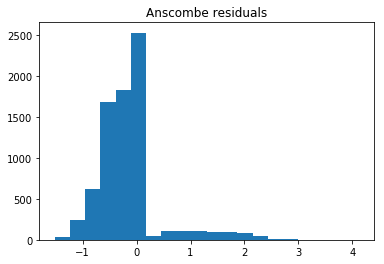

In [20]:
plt.figure()
plt.hist(sppmm_results.resid_anscombe, bins=20)
plt.title('Anscombe residuals')
plt.show()

In [21]:
element_gameweek_df['deviance_residual'] = sppmm_results.resid_deviance
element_gameweek_df['abs_deviance_residual'] = abs(sppmm_results.resid_deviance)
element_gameweek_df['raw_residual'] = sppmm_results.resid_response
element_gameweek_df['abs_raw_residual'] = abs(sppmm_results.resid_response)

#### Deviance contribution by opposition team

In [22]:
element_gameweek_df.groupby('opposition_team')['abs_raw_residual'].mean().sort_values()

opposition_team
12    0.079758
13    0.095449
17    0.125930
6     0.133594
20    0.141057
15    0.145542
1     0.147759
14    0.151846
8     0.154342
3     0.157338
18    0.157683
11    0.162279
7     0.162873
16    0.163075
19    0.165379
10    0.172954
2     0.186770
5     0.192934
4     0.193452
9     0.205269
Name: abs_raw_residual, dtype: float64

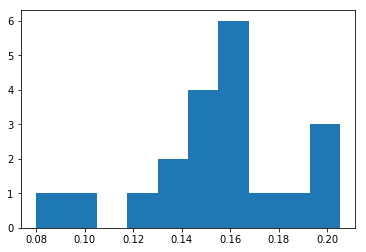

In [23]:
plt.figure()
plt.hist(element_gameweek_df.groupby('opposition_team')['abs_raw_residual'].mean())
plt.show()

#### Deviance contribution by player

In [24]:
element_gameweek_df.groupby(['element', 'safe_web_name'])['minutes'].sum().sort_values()[:20]

element  safe_web_name
443      souare            1
148      sako              1
603      chong             1
602      garner            1
557      camacho           1
562      johnson           1
523      amos              2
566      willock           2
497      nkoudou           4
588      barreca           4
552      nketiah           5
563      saka              7
568      gomes             9
574      gallagher         9
608      greenwood        10
599      surridge         10
10       mavropanos       11
377      prodl            13
607      rowe             14
560      xande silva      17
Name: minutes, dtype: int64

In [25]:
element_gameweek_df.groupby(['element', 'safe_web_name'])['abs_raw_residual'].mean().sort_values()[:20]

element  safe_web_name
491      gibson           3.108624e-15
216      fuchs            7.444185e-13
568      gomes            7.444188e-13
114      cahill           7.444189e-13
605      johnson          7.444192e-13
565      ramsay           7.444194e-13
594      markovic         7.444195e-13
342      sims             7.444195e-13
32       simpson          7.444196e-13
557      camacho          7.444198e-13
601      duhaney          7.444199e-13
602      garner           7.444199e-13
563      saka             7.444199e-13
385      navarro          7.444199e-13
562      johnson          7.444200e-13
10       mavropanos       7.444201e-13
588      barreca          7.444203e-13
377      prodl            7.444206e-13
497      nkoudou          7.444206e-13
232      diabate          7.444206e-13
Name: abs_raw_residual, dtype: float64

In [26]:
element_gameweek_df.groupby(['element', 'safe_web_name'])['abs_raw_residual'].mean().sort_values()[-20:]

element  safe_web_name
18       mkhitaryan       0.464152
437      jimenez          0.491481
45       king             0.493497
372      kane             0.494006
43       wilson           0.494034
480      mitrovic         0.494547
367      son              0.499363
258      ings             0.503769
306      lukaku           0.503804
579      higuain          0.510979
393      richarlison      0.517159
302      pogba            0.530862
253      salah            0.533282
257      firmino          0.549603
23       aubameyang       0.550326
234      vardy            0.551192
122      hazard           0.602291
251      mane             0.607381
270      sterling         0.615791
280      aguero           0.720521
Name: abs_raw_residual, dtype: float64

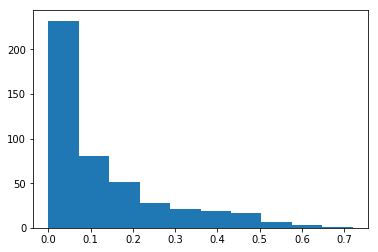

In [27]:
plt.figure()
plt.hist(element_gameweek_df.groupby(['element', 'safe_web_name'])['abs_raw_residual'].mean())
plt.show()

#### Deviance contribution by minutes played

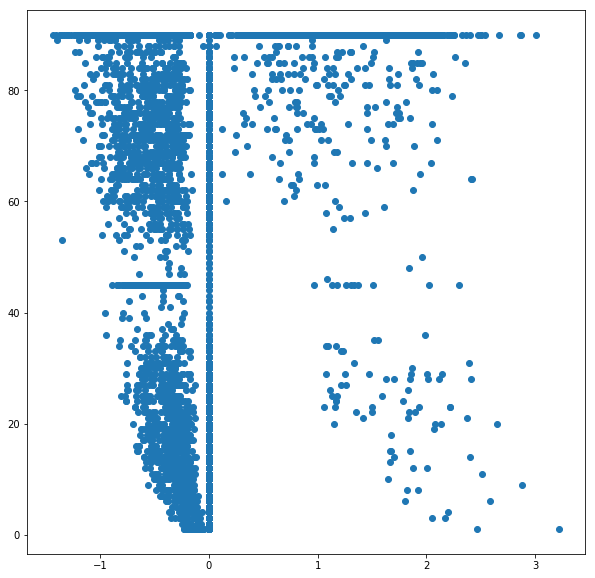

In [28]:
plt.figure(figsize=(10, 10))
plt.scatter(element_gameweek_df['deviance_residual'], element_gameweek_df['minutes'])
plt.show()

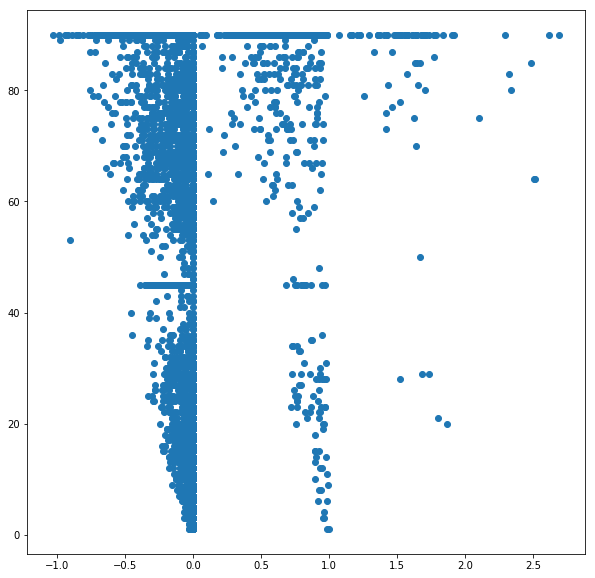

In [29]:
plt.figure(figsize=(10, 10))
plt.scatter(element_gameweek_df['raw_residual'], element_gameweek_df['minutes'])
plt.show()

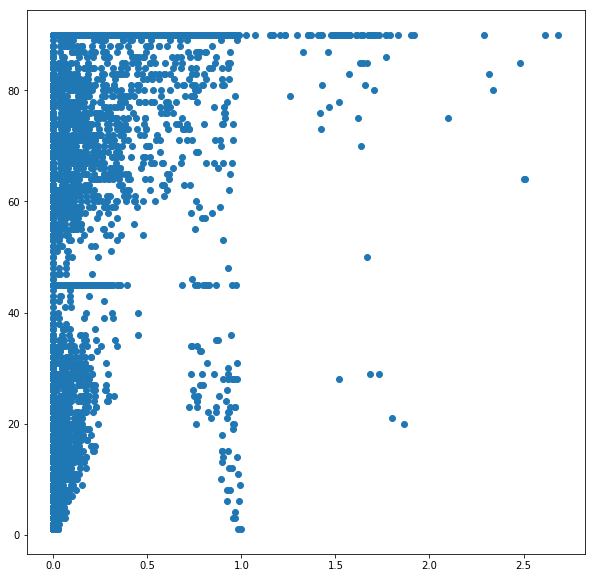

In [30]:
plt.figure(figsize=(10, 10))
plt.scatter(element_gameweek_df['abs_raw_residual'], element_gameweek_df['minutes'])
plt.show()

In [31]:
element_gameweek_df['minutes_binned'] = pd.cut(element_gameweek_df['minutes'], 10)

In [32]:
element_gameweek_df.groupby('minutes_binned')['abs_raw_residual'].mean().sort_index()

minutes_binned
(0.911, 9.9]    0.032178
(9.9, 18.8]     0.060952
(18.8, 27.7]    0.123336
(27.7, 36.6]    0.158980
(36.6, 45.5]    0.102429
(45.5, 54.4]    0.128949
(54.4, 63.3]    0.135048
(63.3, 72.2]    0.192651
(72.2, 81.1]    0.237710
(81.1, 90.0]    0.171729
Name: abs_raw_residual, dtype: float64

In [33]:
element_gameweek_df.groupby('minutes_binned')['abs_raw_residual'].std().sort_index()

minutes_binned
(0.911, 9.9]    0.139353
(9.9, 18.8]     0.141943
(18.8, 27.7]    0.247776
(27.7, 36.6]    0.297475
(36.6, 45.5]    0.174784
(45.5, 54.4]    0.271277
(54.4, 63.3]    0.188830
(63.3, 72.2]    0.268036
(72.2, 81.1]    0.323008
(81.1, 90.0]    0.287019
Name: abs_raw_residual, dtype: float64

#### Deviance contribution by element type

In [34]:
element_gameweek_df.groupby('element_type')['abs_raw_residual'].mean().sort_values()

element_type
2    0.070938
3    0.168181
4    0.300272
Name: abs_raw_residual, dtype: float64

#### Deviance contribution by goals scored

In [35]:
element_gameweek_df.groupby('goals_scored')['abs_raw_residual'].mean().sort_values()

goals_scored
0    0.085497
1    0.707807
2    1.535966
3    2.426230
Name: abs_raw_residual, dtype: float64

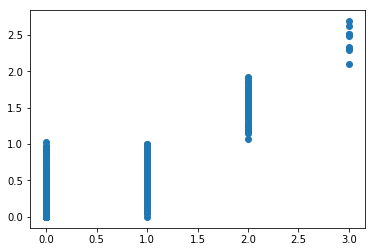

In [36]:
plt.figure()
plt.scatter(element_gameweek_df['goals_scored'], element_gameweek_df['abs_raw_residual'])
plt.show()